# TUIA NLP 2024 TRABAJO PRÁCTICO 1

**Materia:** Procesamiento del Lenguaje Natural (IA 4.2)

**Año académico:** 2024

**Período lectivo:** 1° cuatrimestre

**Integrantes:**

- Britos Julián Francisco
- Moresco Brisa

#### Objetivo

El objetivo de este proyecto es desarrollar un programa que interactúe con el usuario para recomendar lecturas. 

#### Opciones principales

El programa ofrecerá tres opciones principales:

- Recomendación Directa: El programa preguntará al usuario "¿Qué tienes ganas de leer hoy?" y, mediante la clasificación de la respuesta, propondrá una lista de tres libros acordes a las temáticas mencionadas. Además, se detallará el autor, género y una breve reseña de cada libro que se recomienda descargar.

- Elección por Autor: Si el usuario prefiere buscar por autor, el programa ofrecerá una lista de libros del autor especificado. En caso de que haya múltiples resultados, se basará en la similitud de los dos primeros resultados más relevantes, retornando dos títulos (con sus respectivas reseñas) del resultado más cercano y uno del segundo que se recomiendan para descargar. Si existen varios libros del mismo autor aleatorizar. 

- Elección por Género Literario: Similar a la búsqueda por autor, si el usuario elige buscar por género, el programa ofrecerá una lista de libros del género especificado. Aplicará la misma lógica de similitud para seleccionar y presentar los resultados.


# Librerías

In [1]:
# !pip install streamlit
# !pip install requests
# !pip install beautifulsoup4

In [2]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Obtención de datos y creación del dataset 

# **(NO EJECUTAR A MENOS QUE SE PIERDA EL DATASET)**

In [41]:
url_base = "https://ww3.lectulandia.com/"
response = requests.get(url_base)
soup = BeautifulSoup(response.text, 'html.parser')

# Encuentra el enlace relativo para la página de libros (/book/)
link_element = soup.select_one('#site-navigation > ul > li:nth-child(2) > a')
url_relativa = link_element['href']

# Combina la URL base con el URL relativo para obtener un URL absoluto (https://ww3.lectulandia.com/book/)
url_absoluta = urljoin(url_base, url_relativa)

# Hacemos una solicitud a la url absoluta para obtener la página a la que apunta el enlace, es decir la pagina con todos los libros
link_response = requests.get(url_absoluta)
link_soup = BeautifulSoup(link_response.text, 'html.parser')

# Crea la carpeta 'img' si aún no existe
if not os.path.exists('img'):
    os.makedirs('img')

Primero, obtenemos cada página y cada libro en cada página. Luego obtenemos el título, género/s, autor/es, descripción y foto de cada libro. 

In [37]:
# Establecemos el número de páginas que queremos recorrer.
n_pags = 50 # No puede ser menor a 1, ya que la página principal cuenta como la primera página.

# Creamos una lista vacía para almacenar nuestros datos.
data = []

for i in range(1, n_pags + 1):
    # Hacemos una solicitud a la url de la página i.    
    link_response = requests.get(url_absoluta + f'page/{i}/')
    link_soup = BeautifulSoup(link_response.text, 'html.parser')
    
    # Iteramos sobre cada libro en la página.
    for libro in link_soup.select('article.card'):
        # Extrae el url de cada libro de la página i.
        url_relativa_libro = libro.select_one('h2 > a.title').get('href')
        # Combina la URL base con el URL relativo para obtener un URL absoluto (https://ww3.lectulandia.com/book/libro-de-ejemplo-1)
        url_absoluta_libro = urljoin(url_base, url_relativa_libro)
        # Imprimimos el url de cada libro.
        #print(f'url: {url_absoluta_libro}')
        # Creamos una lista con los urls de los libros y añadimos el url de cada libro a la lista.
        url_absoluta_libros = []
        url_absoluta_libros.append(url_absoluta_libro)
        # Hacemos una solicitud a la url de cada libro.
        libro_response = requests.get(url_absoluta_libro)
        libro_soup = BeautifulSoup(libro_response.text, 'html.parser')
        
        # Extraemos el título de cada libro.
        titulo = libro_soup.find(id='title').find('h1').text
        #print(f'Titulo: {titulo}')

        # Extraemos el autor de cada libro.
        autores_elements = libro_soup.find(id='autor').find_all('a')
        x_autores = [autor.text for autor in autores_elements]
        #print(f'Autores:\n   {x_autores}')
        # Creamos una lista con los autores de los libros y añadimos el autor de cada libro a la lista.
        autores = []
        autores.append(x_autores)
    
        # Extraemos el género de cada libro.
        generos_elements = libro_soup.find(id='genero').find_all('a')
        x_generos = [genero.text for genero in generos_elements]
        #print(f'Generos:\n   {x_generos}')
        # Creamos una lista con los géneros de los libros y añadimos el género de cada libro a la lista.
        generos = []
        generos.append(x_generos)

        # Extraemos la sinopsis de cada libro.
        sinopsis_element = libro_soup.find('div', class_='realign', id='sinopsis')
        if sinopsis_element is not None:
            span_element = sinopsis_element.find('span')
            if span_element is not None:
                sinopsis = span_element.text
            else:
                sinopsis = ''
        else:
            sinopsis = ''
        #print(sinopsis_element)
        #print(f'Sinopsis:\n   {sinopsis}')
        # Creamos una lista con las sinopsis de los libros y añadimos la sinopsis de cada libro a la lista.
        sinopsis_libros = []
        sinopsis_libros.append(sinopsis)

        # Descargamos la imagen de cada libro.
        img_url = libro_soup.find(id='cover').find('img').get('src')
        img_response = requests.get(img_url)
        img = img_response.content
        # Limpiamos el título para que no contenga caracteres no permitidos en un nombre de archivo.
        titulo_limpio = titulo.replace(' ', '_').replace(':', '').replace('/', '_').replace('?', '')
        # Guardamos la imagen en un archivo en la carpeta 'img'.
        with open(f'img/{titulo_limpio}.jpg', 'wb') as file:
            file.write(img)
        #print(f'Imagen guardada en img/{titulo_limpio}.jpg')

        data.append({
            'Titulo': titulo,
            'Autor': autores,
            'Genero': generos,
            'Descripcion': sinopsis
            })
        
    print(url_absoluta + f'page/{i}/ ✔️')

        
libros = pd.DataFrame(data)

https://ww3.lectulandia.com/book/page/1/ ✔️
https://ww3.lectulandia.com/book/page/2/ ✔️
https://ww3.lectulandia.com/book/page/3/ ✔️
https://ww3.lectulandia.com/book/page/4/ ✔️
https://ww3.lectulandia.com/book/page/5/ ✔️
https://ww3.lectulandia.com/book/page/6/ ✔️
https://ww3.lectulandia.com/book/page/7/ ✔️
https://ww3.lectulandia.com/book/page/8/ ✔️
https://ww3.lectulandia.com/book/page/9/ ✔️
https://ww3.lectulandia.com/book/page/10/ ✔️
https://ww3.lectulandia.com/book/page/11/ ✔️
https://ww3.lectulandia.com/book/page/12/ ✔️
https://ww3.lectulandia.com/book/page/13/ ✔️
https://ww3.lectulandia.com/book/page/14/ ✔️
https://ww3.lectulandia.com/book/page/15/ ✔️
https://ww3.lectulandia.com/book/page/16/ ✔️
https://ww3.lectulandia.com/book/page/17/ ✔️
https://ww3.lectulandia.com/book/page/18/ ✔️
https://ww3.lectulandia.com/book/page/19/ ✔️
https://ww3.lectulandia.com/book/page/20/ ✔️
https://ww3.lectulandia.com/book/page/21/ ✔️
https://ww3.lectulandia.com/book/page/22/ ✔️
https://ww3.lectula

In [38]:
# Recorremos cada columna del DataFrame y, si el valor en esa columna es una lista con al menos un elemento, lo reemplazará con el primer elemento de la lista. Si el valor no es una lista o es una lista vacía, se mantendrá como está.
for column in libros.columns:
    libros[column] = libros[column].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

In [12]:
libros.to_csv('Libros.csv', index=False)

In [10]:
libros

,Titulo,Autor,Genero,Descripcion
0,Le dedico mi silencio,[Mario Vargas Llosa],"[Drama, Novela]",La historia de un hombre que soñó un país unid...
1,Mentideros de la memoria,[Gonzalo Celorio],"[Histórico, Novela]","Entre la ficción y el testimonio, el ensayo y ..."
2,¡A mí me lo vas a contar!,[Daniel de la Peña],"[Erótico, Humor, Novela, Romántico]",Cuando el destino se empeña en poner en tu cam...
3,Identidad oculta,[Eugeni Verdú],"[Intriga, Novela]",UN THRILLER POLICIACO QUE NOS SUMERGE EN EL LA...
4,Vox y el Yunque,[Santiago Mata],"[Ensayo, Política]",Esta investigación se refiere a quienes se apo...
...,...,...,...,...
1195,Hija de la lluvia,[Haizea López],"[Intriga, Novela]",La maldición persigue a la familia Agirregoiti...
1196,Tiniebla,[Paul Kawczak],"[Drama, Novela]","Una mañana de septiembre de 1890, el topógrafo..."
1197,Valió la pena,[Jorge Dezcallar de Mazarredo],"[Crónica, Memorias]",Jorge Dezcallar de Mazarredo quiso ser diplomá...
1198,Los Tres Gordinflones,[Yuri Olesha],"[Fantástico, Novela]",La solidaridad y la amistad serán las únicas f...


# Carga de datos

In [3]:
file_path= 'Libros.csv'
libros = pd.read_csv(file_path, sep=',',engine='python')

# Convertir las cadenas de texto a listas
libros['Genero'] = libros['Genero'].apply(ast.literal_eval)
libros['Autor'] = libros['Autor'].apply(ast.literal_eval)

# Análisis estadístico descriptivo

## Visualización de datos

In [4]:
libros.head()

,Titulo,Autor,Genero,Descripcion
0,Le dedico mi silencio,[Mario Vargas Llosa],"[Drama, Novela]",La historia de un hombre que soñó un país unid...
1,Mentideros de la memoria,[Gonzalo Celorio],"[Histórico, Novela]","Entre la ficción y el testimonio, el ensayo y ..."
2,¡A mí me lo vas a contar!,[Daniel de la Peña],"[Erótico, Humor, Novela, Romántico]",Cuando el destino se empeña en poner en tu cam...
3,Identidad oculta,[Eugeni Verdú],"[Intriga, Novela]",UN THRILLER POLICIACO QUE NOS SUMERGE EN EL LA...
4,Vox y el Yunque,[Santiago Mata],"[Ensayo, Política]",Esta investigación se refiere a quienes se apo...


In [5]:
libros.isna().sum()

Titulo         0
Autor          0
Genero         0
Descripcion    4
dtype: int64

Vemos que hay 4 sinopsis con valores nulos, es decir NaN, esto sabemos que se debe a que el formato HTML de la página de donde se extrajo el dataset todas las sinopsis están entre 'span', sin embargo, algunos libros tiene  el formato de su sinopsis mal hecho lo que hace que nuestro código no pueda detectar que exista esa sinopsis y no logremos guardarla. Sin embargo, esto no es un problema, ya que al tener tantos libros en nuestro dataset, podemos darnos el lujo de eliminar estos 4 y así evitar problemas futuros.

In [26]:
libros = libros.dropna()
libros.isna().sum()

Titulo         0
Autor          0
Genero         0
Descripcion    0
dtype: int64

In [27]:
libros.describe()

,Titulo,Autor,Genero,Descripcion
count,1196,1196,1196,1196
unique,1137,888,279,1134
top,Vuelve a amar tu caos y el roce de vivir,"[Goretti Irisarri, Jose Gil Romero]","[Novela, Otros]","Nacido en la Misia oriental en 117, Elio Arist..."
freq,2,11,68,5


Aquí vemos cómo él describe nos muestra que existen  889 valores únicos para autores y  279  valores únicos para géneros, sin embargo, los libros al poder tener más de un autor o genero la solución que buscamos a la hora de crear el dataset fue ponerlos en listas y este formato es que puede causar que el 'describe' no esté realmente mostrando los valores únicos, ya que por ejemplo si tenemos ['Batalla', 'Novela'] y ['Novela'] el 'describe' tomará que hay dos géneros totales y dos géneros únicos cuando realmente hay 3 géneros totales, pero solamente 2 únicos para solucionar esto hacemos: 

In [28]:
generos_unicos = libros['Genero'].explode().unique()
autores_unicos = libros['Autor'].explode().unique()
generos_unicos.size, autores_unicos.size

(72, 999)

Ahora sí podemos ver cuantos géneros y autores existen realmente, siendo estos 72 y 1000 correspondientemente.

## Gráficos

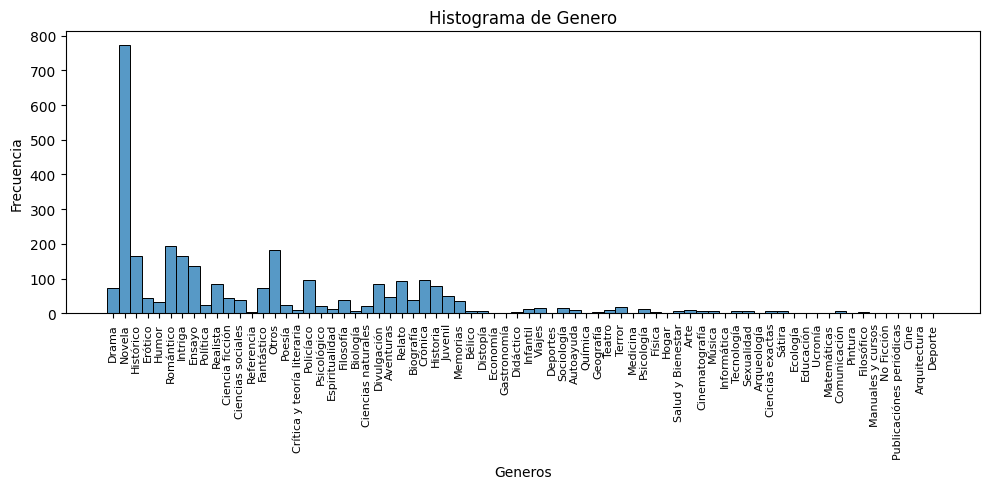

In [23]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma       creamos un dataframe con los generos de la sublista de generos de cada libro      
sns.histplot(pd.DataFrame([genero for sublist in libros['Genero'] for genero in sublist], columns=['Genero'])['Genero'])
axs.set_title('Histograma de Genero')
axs.set_xlabel('Generos')
axs.set_ylabel('Frecuencia')

plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

# Representación Vectorial de Texto